In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from riskyneuroarousal.utils.load_data import (load_behavioral_data, load_pupil_data)
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data()
data = pupil_data.merge(behavior, on=["sub", "trial"])
data["pupil_size"] = data["ps_preprocessed"] - data["baseline"]
data["loss_over_gain"] = np.log(data["loss"] / data["gain"])

In [14]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)
library(dplyr)
library(broom.mixed)

In [15]:
%%R -o residual_pupil
# loop through timebins
residual_pupil <- data.frame()
# Create a copy of data with sub, loss_over_gain, gain, loss, condition

for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed
    model = lmer(pupil_size ~ RT*condition + blink*condition + (1| sub) + (-1 + RT|sub) + (-1 + blink | sub), data=data[data$timebin == tb, ])

    # Gather results
    residuals <- residuals(model)
    results <- data.frame(pupil_residual = residuals, 
                        timebin = tb, 
                        sub = data[data$timebin == tb, "sub"], 
                        gain = data[data$timebin == tb, "gain"], 
                        loss = data[data$timebin == tb, "loss"], 
                        condition = data[data$timebin == tb, "condition"], 
                        RT = data[data$timebin == tb, "RT"],
                        accept = data[data$timebin == tb, "accept"], 
                        loss_over_gain = data[data$timebin == tb, "loss_over_gain"])
    residual_pupil <- rbind(residual_pupil, results)
}

boundary (singular) fit: see help('isSingular')
In addition: Warning messages:
1: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00274893 (tol = 0.002, component 1)
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00242003 (tol = 0.002, component 1)
3: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00278892 (tol = 0.002, component 1)


In [17]:
# Create 3 quantiles of loss_over_gain
residual_pupil["loss_gain_quantile"] = pd.qcut(residual_pupil["loss_over_gain"], 3, labels=["Good", "Okay", "Bad"])

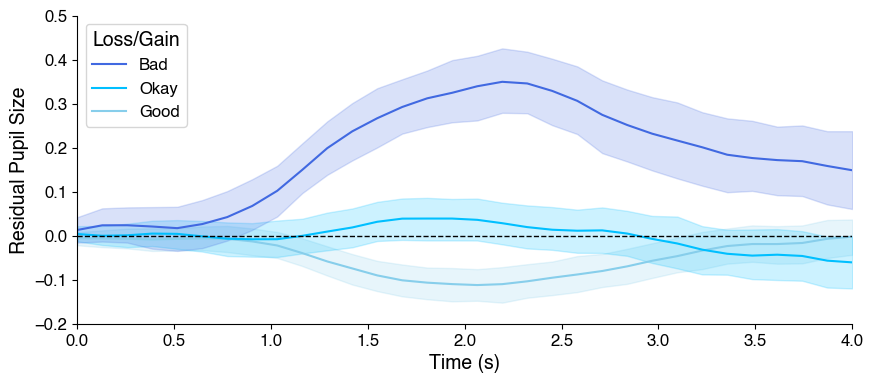

In [21]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'skyblue', 'Okay': 'deepskyblue', 'Bad': 'royalblue'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalIndifference'"), x="timebin", y="pupil_residual", hue="loss_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.50)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Bad', 'Okay', 'Good']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss/Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

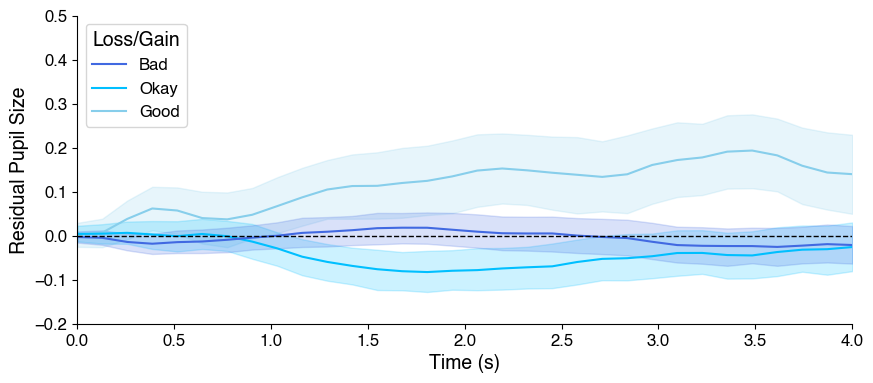

In [22]:
plt.rcParams["font.family"] = "Helvetica"
color_palette = {'Good': 'skyblue', 'Okay': 'deepskyblue', 'Bad': 'royalblue'}
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=residual_pupil.query("condition == 'equalRange'"), x="timebin", y="pupil_residual", hue="loss_gain_quantile", palette=color_palette, ax=ax)
# remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# Axis labels, and size
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Residual Pupil Size", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xlim(0, 4)
ax.set_ylim(-0.2, 0.50)
# Set order of legend
handles, labels = ax.get_legend_handles_labels()
order = ['Bad', 'Okay', 'Good']
handles = [handles[labels.index(o)] for o in order]
plt.legend(handles=handles, title="Loss/Gain", fontsize=12, title_fontsize=14)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()